In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot


from keras.layers import Dense,Embedding,LSTM,Bidirectional
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer,one_hot
from keras.preprocessing.sequence import pad_sequences
import nltk
import re
import string
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [112]:
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

final_stopwords_list = list(fr_stop) + list(en_stop)

In [113]:
#loading the english news dataset
df=pd.read_csv("USNews.csv")
df.dropna(inplace=True)
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [114]:
##loading the french data set
dff=pd.read_csv('FranceNews.csv')
dff.rename(columns = {'fake':'label'}, inplace = True)
dff.dropna(inplace=True)
dff.head(3)

,news,url,source,author,title,theme,description,date_published,body,label,text,train,nb_words,fake_pred,fp,fn,fake_pred_logreg,fp_logreg,fn_logreg
0,1,https://www.liberation.fr/france/2019/12/15/le...,Liberation,Nathalie Raulin,Les chefs de service hospitaliers en appellent...,france,Jugeant très insuffisante la réponse du gouver...,15/12/2019,C’est une menace d’une démission collective qu...,0,Les chefs de service hospitaliers en appellent...,False,789,0,False,False,0,False,False
1,2,https://www.futura-sciences.com/sante/actualit...,Futura Sciences,Futura avec Relaxnews,L'origine des comportements alimentaires ident...,sante,D'après une étude publiée dans la revue,16/12/2019,D'après une étude publiée dans la revue Natur...,0,L'origine des comportements alimentaires ident...,True,499,0,False,False,0,False,False
2,3,https://www.futura-sciences.com/tech/actualite...,Futura Sciences,Louis Neveu,Microsoft alerte sur de nouvelles techniques d...,tech,Le géant de l'informatique Microsoft vient de ...,16/12/2019,Le géant de l'informatique Microsoft vient de ...,0,Microsoft alerte sur de nouvelles techniques d...,True,412,0,False,False,0,False,False


## Count of fake and real news

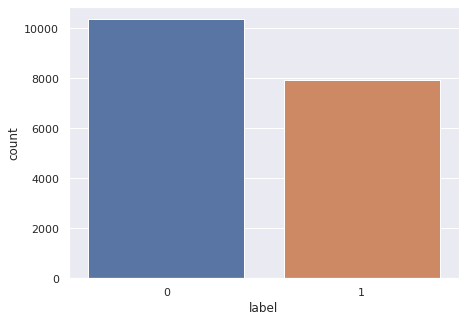

In [115]:
sns.set(rc={'figure.figsize':(7,5)})
sns.countplot(df['label'])

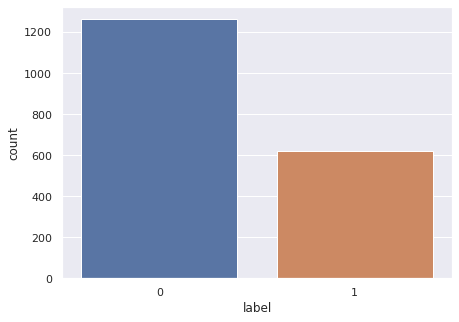

In [116]:
sns.set(rc={'figure.figsize':(7,5)})
sns.countplot(dff['label'])

## Distribution of Article Length (Word Count)¶


Text(0.5, 1.0, 'Word count distribution of Fake News')

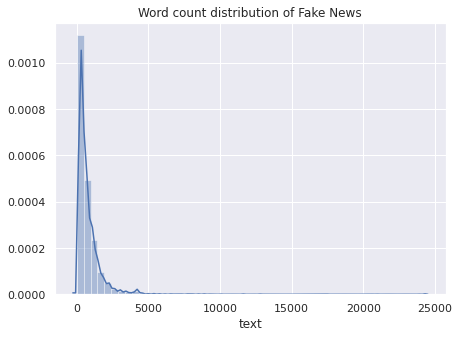

In [117]:
sns.distplot(df[df['label']==1]['text'].apply(lambda x: len(str(x).split(' ')))).set_title('Word count distribution of Fake News')

Text(0.5, 1.0, 'Word count distribution of Real News')

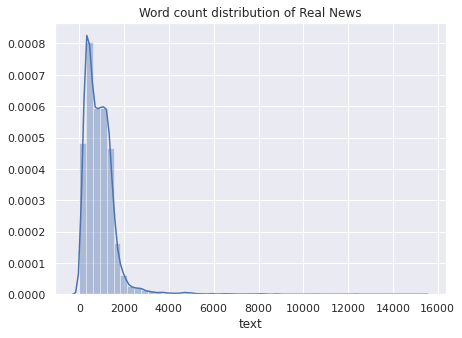

In [118]:
sns.distplot(df[df['label']==0]['text'].apply(lambda x: len(str(x).split(' ')))).set_title('Word count distribution of Real News')

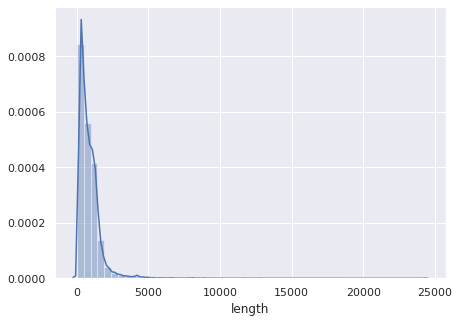

In [119]:
df['length'] = df['text'].apply(lambda x: len(str(x).split(' ')))
sns.distplot(df['length'])

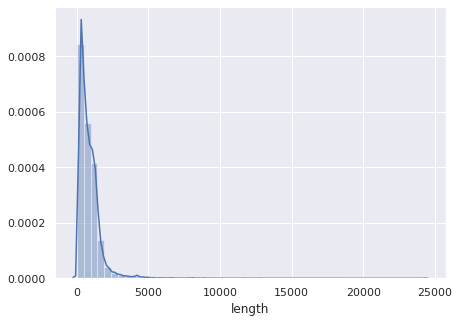

In [120]:
df['length'] = df['text'].apply(lambda x: len(str(x).split(' ')))
sns.distplot(df['length'])

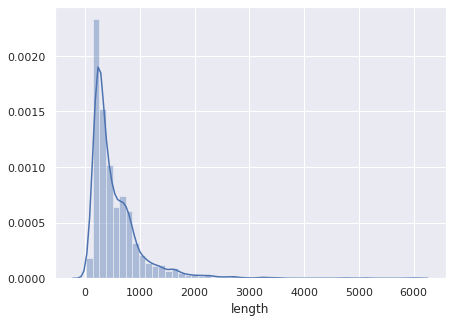

In [121]:
dff['length'] = dff['text'].apply(lambda x: len(str(x).split(' ')))
sns.distplot(dff['length'])

## Wordcloud of fake and real news America

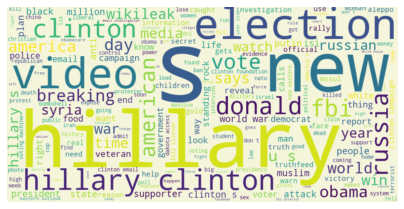

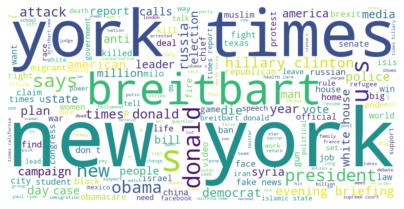

In [166]:
#filter the df to one candidate, and create a list of responses from them
text = df[df.label==1].title.astype(str).tolist() 

# join the list and lowercase all the words
text = ' '.join(text).lower()

#create the wordcloud object
wordcloud = WordCloud(stopwords = STOPWORDS.add('trump'),background_color="beige",width=1000, height=500,max_font_size=256,
                      collocations=True).generate(text)

#plot the wordcloud object
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

#filter the df to one candidate, and create a list of responses from them
text = df[df.label==0].title.astype(str).tolist() 

# join the list and lowercase all the words
text = ' '.join(text).lower()

#create the wordcloud object
wordcloud = WordCloud(stopwords = STOPWORDS.add('trump'),background_color="white",width=1000, height=500,max_font_size=256,
                      collocations=True).generate(text)

#plot the wordcloud object
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()


## TOPIC Modelling-LDA

In [123]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(analyzer='word', stop_words='english')
dtm = cv.fit_transform(df['title'])
from sklearn.decomposition import LatentDirichletAllocation
# Build LDA Model with GridSearch params
lda_model = LatentDirichletAllocation(n_components=5,     random_state=0)                
lda_output = lda_model.fit_transform(dtm)


In [124]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [125]:
panel = pyLDAvis.sklearn.prepare(lda_model, dtm, cv, mds='tsne')

In [126]:
panel


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      150.222153  -72.269554       1        1  36.506075
2       51.163364 -159.968018       2        1  20.143837
3      -73.144554   21.523815       3        1  16.421700
0      -66.410133 -110.606438       4        1  13.862759
4       54.417324   12.443444       5        1  13.065629, topic_info=            Term         Freq        Total Category  logprob  loglift
12084        new  6268.000000  6268.000000  Default  30.0000  30.0000
19911       york  5659.000000  5659.000000  Default  29.0000  29.0000
18042      times  5625.000000  5625.000000  Default  28.0000  28.0000
2519   breitbart  2117.000000  2117.000000  Default  27.0000  27.0000
18403      trump  3086.000000  3086.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
960      america    54.986540   268.170661   Topic5  -5.9099   0.4507
155         2016    52.014907   197.594557   Topic5  -5.9655   0.7005
1459      attack    49.638084   189.092381   Topic5  -6.0122   0.6977
5975       email    47.064105   123.107270   Topic5  -6.0655   1.0736
1099        anti    47.548664   198.179587   Topic5  -6.0552   0.6078

[368 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
0          1  0.102156    000
0          2  0.145937    000
0          3  0.153234    000
0          4  0.488890    000
0          5  0.109453    000
...      ...       ...    ...
19873      3  0.337669  years
19873      4  0.196973  years
19911      1  0.999857   york
19986      3  0.073434   zone
19986      5  0.917921   zone

[646 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1, 5])

## Wordcloud of fake and real news France

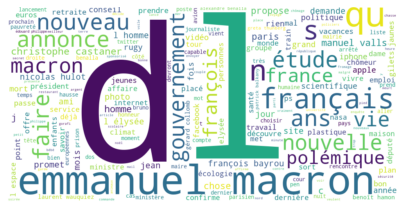

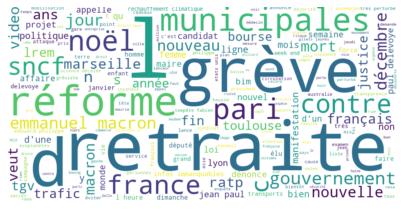

In [158]:
#filter the df to one candidate, and create a list of responses from them
text = dff[dff.label==1].title.astype(str).tolist() 

# join the list and lowercase all the words
text = ' '.join(text).lower()

#create the wordcloud object
wordcloud = WordCloud(stopwords = STOPWORDS.update(final_stopwords_list),background_color="white",width=1000, height=500,
                      collocations=True).generate(text)

#plot the wordcloud object
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

#filter the df to one candidate, and create a list of responses from them
text = dff[dff.label==0].title.astype(str).tolist() 

# join the list and lowercase all the words
text = ' '.join(text).lower()

#create the wordcloud object
wordcloud = WordCloud(stopwords = STOPWORDS.update(final_stopwords_list),background_color="white",width=1000, height=500,
                      collocations=True).generate(text)

#plot the wordcloud object
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

## Sentiment analysis English


In [128]:
sid = SentimentIntensityAnalyzer()
df['scores'] = df['title'].apply(lambda review: sid.polarity_scores(review))
df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
df['comp_score'] = df['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')
df.head()

,id,title,author,text,label,length,scores,compound,comp_score
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,820,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,727,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,1266,"{'neg': 0.33, 'neu': 0.459, 'pos': 0.211, 'com...",-0.3182,neg
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,559,"{'neg': 0.333, 'neu': 0.667, 'pos': 0.0, 'comp...",-0.6705,neg
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,154,"{'neg': 0.372, 'neu': 0.628, 'pos': 0.0, 'comp...",-0.7964,neg


In [147]:
## previewing sentiment score
import random

print(colored('5 random reviews with the highest positive sentiment polarity: \n',  'green', attrs=['bold']))
cl = df.loc[df.comp_score == 'pos', ['title']].sample(5).values
for c in cl:
    random.seed(10)
    print(c[0])

## previewing sentiment score
print(colored('5 random reviews with the highest negative sentiment polarity: \n',  'red', attrs=['bold']))
cl = df.loc[df.comp_score == 'neg', ['title']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the highest positive sentiment polarity: 

Beyond Coal: Imagining Appalachia’s Future - The New York Times
The Left’s Vision
How ’Art of the Deal’ Explains the Obamacare Replacement Debate
How To Live After Trump
UK Conservatives Hire Senior Obama Aide to Help Election Campaign
5 random reviews with the highest negative sentiment polarity: 

Britain’s Mainstream Media Blames ’Racism’ for Westminster Attack
In Desperate Pursuit of the Zero-Stress Job - The New York Times
Harassment Crisis Builds at Fox News, Despite Its Swift Response - The New York Times
Train Crash in Italy Leaves at Least 25 Dead and Dozens Injured - The New York Times
Syria Cease-Fire Crumbles as Bombings Kill Dozens - The New York Times


## Sentiment analysis french

In [130]:
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer 
SIA = SentimentIntensityAnalyzer()

phrase = 'Une phrase très cool à analyser'

score = SIA.polarity_scores(phrase)
dff['scores'] = dff['title'].apply(lambda review: SIA.polarity_scores(review))
dff['compound']  = dff['scores'].apply(lambda score_dict: score_dict['compound'])
dff['comp_score'] = dff['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')
dff.head()

,news,url,source,author,title,theme,description,date_published,body,label,...,fake_pred,fp,fn,fake_pred_logreg,fp_logreg,fn_logreg,length,scores,compound,comp_score
0,1,https://www.liberation.fr/france/2019/12/15/le...,Liberation,Nathalie Raulin,Les chefs de service hospitaliers en appellent...,france,Jugeant très insuffisante la réponse du gouver...,15/12/2019,C’est une menace d’une démission collective qu...,0,...,0,False,False,0,False,False,835,"{'neg': 0.18, 'neu': 0.82, 'pos': 0.0, 'compou...",-0.2960,neg
1,2,https://www.futura-sciences.com/sante/actualit...,Futura Sciences,Futura avec Relaxnews,L'origine des comportements alimentaires ident...,sante,D'après une étude publiée dans la revue,16/12/2019,D'après une étude publiée dans la revue Natur...,0,...,0,False,False,0,False,False,575,"{'neg': 0.0, 'neu': 0.682, 'pos': 0.318, 'comp...",0.5766,pos
2,3,https://www.futura-sciences.com/tech/actualite...,Futura Sciences,Louis Neveu,Microsoft alerte sur de nouvelles techniques d...,tech,Le géant de l'informatique Microsoft vient de ...,16/12/2019,Le géant de l'informatique Microsoft vient de ...,0,...,0,False,False,0,False,False,447,"{'neg': 0.113, 'neu': 0.755, 'pos': 0.132, 'co...",0.0516,pos
3,4,https://www.futura-sciences.com/sciences/actua...,Futura Sciences,Rémy Decourt,L'Europe se dote d'une infrastructure de téléc...,sciences,Pour garantir la sécurité de la libre circulat...,16/12/2019,Pour garantir la sécurité de la libre circulat...,0,...,0,False,False,0,False,False,1425,"{'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'comp...",0.5766,pos
4,6,https://www.futura-sciences.com/sciences/actua...,Futura Sciences,Nathalie Mayer,Science décalée : la créature la plus rapide s...,sciences,Le guépard est l'animal le plus rapide... sur ...,15/12/2019,Le guépard est l'animal le plus rapide... sur ...,0,...,0,False,False,0,False,False,639,"{'neg': 0.08, 'neu': 0.92, 'pos': 0.0, 'compou...",-0.0762,neg


In [131]:
## previewing sentiment score
import random

print(colored('5 random reviews with the highest positive sentiment polarity: \n',  'green', attrs=['bold']))
cl = dff.loc[dff.comp_score == 'pos', ['title']].sample(5).values
for c in cl:
    random.seed(10)
    print(c[0])

## previewing sentiment score
print(colored('5 random reviews with the highest negative sentiment polarity: \n',  'red', attrs=['bold']))
cl = dff.loc[dff.comp_score == 'neg', ['title']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the highest positive sentiment polarity: 

Réchauffement climatique : les modèles climatiques ont vu juste depuis le début
Brésil : Jair Bolsonaro est parti pour durer
Voici la première doudoune en soie d'araignée
La luminosité d’une pièce influence notre perception de la température
Emmanuel Macron  « Je n’aime pas le mot de démocratie parce que ça donne le sentiment que le peuple aurait le pouvoir »
5 random reviews with the highest negative sentiment polarity: 

Grève à la SNCF : La compagnie prévoit un trafic « très perturbé » samedi et dimanche, la moitié des TGV en circulation
Prêtre tué dans l’Oise : Le suspect mis en examen pour meurtre aggravé
Toute sa famille disparaît sans donner de nouvelles pendant qu’il va chercher un paquet de cigarettes
Seveso – L’état va démanteler les villes trop proches des usines à risques
Grève 5 décembre : Marine Le Pen a-t-elle changé d’avis sur les manifestations et la grève ?


## Modeling

In [132]:
## we add a dataset created from our own from the most viewed fake news of the decade

In [133]:
##adding my own datasset for test
test=pd.read_csv('test1.csv')
test.head()

,title
0,Joe Biden Calls Trump Supporters 'Dregs of Soc...
1,NYC coroner who declared the death of Jeffrey ...
2,Tim Allen quote Trump’s wall costs less than t...
3,Democrats Vote To Enhance Med Care for Illegal...
4,BREAKING: Nancy Pelosi’s Son Was Exec At Gas C...


In [134]:
test.dtypes

title    object
dtype: object

In [135]:
X=df['title']
y=df['label']

In [136]:
ps=PorterStemmer()

def clean_text(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text=text.lower()
    text=text.strip()
    text=re.sub('Re:','Retweet',text)
    text_token=[t for t in word_tokenize(text) if t not in stopwords.words('english')]
    text=' '.join(text_token)
    text=text.strip()
    return text


df1=df.copy()
df2=test.copy()
df1['title_new']=df1['title'].apply(lambda x: clean_text(str(x)))
df2['title_new']=test['title'].apply(lambda x: clean_text(str(x)))

In [137]:
messages=df1['title_new'].to_list()
messages2=df2['title_new'].to_list()


In [148]:
vocab_size=5000#no of vocab to be considered
length=20#length of sentence

one_hot_repr=[one_hot(word,vocab_size)for word in messages]
onehot_rep_test = [one_hot(words,vocab_size)for words in messages2]

In [149]:
#since length is different for each sentence we will make all sentence length same 
sent_length=20
emb_docs=pad_sequences(one_hot_repr,sent_length,truncating='post',padding='post')

embedded_docs_test = pad_sequences(onehot_rep_test,padding='pre',maxlen=25)#truncat=cut the sentence if lenth is more than 20
#padd 0 at the end if length is small

In [150]:
#creating MODEL
#dimension or output feature  
dim=64 #embedding layer with feature 64
model=Sequential()
model.add(Embedding(vocab_size,dim,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 64)            320000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [151]:
x_final=np.array(emb_docs)
y_final=np.array(df1['label'])


from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_final,y_final,train_size=0.75,random_state=22)


print(x_final.shape,y.shape)

(18285, 20) (18285,)


In [152]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=15,batch_size=64)

Epoch 1/15
215/215 [==============================] - 5s 25ms/step - loss: 0.2866 - accuracy: 0.8642 - val_loss: 0.1674 - val_accuracy: 0.9300
Epoch 2/15
215/215 [==============================] - 5s 23ms/step - loss: 0.1289 - accuracy: 0.9525 - val_loss: 0.1688 - val_accuracy: 0.9335
Epoch 3/15
215/215 [==============================] - 5s 23ms/step - loss: 0.0872 - accuracy: 0.9700 - val_loss: 0.2113 - val_accuracy: 0.9291
Epoch 4/15
215/215 [==============================] - 5s 23ms/step - loss: 0.0666 - accuracy: 0.9770 - val_loss: 0.2279 - val_accuracy: 0.9254
Epoch 5/15
215/215 [==============================] - 5s 23ms/step - loss: 0.0525 - accuracy: 0.9824 - val_loss: 0.2235 - val_accuracy: 0.9217
Epoch 6/15
215/215 [==============================] - 5s 23ms/step - loss: 0.0382 - accuracy: 0.9875 - val_loss: 0.3325 - val_accuracy: 0.9221
Epoch 7/15
215/215 [==============================] - 5s 23ms/step - loss: 0.0286 - accuracy: 0.9912 - val_loss: 0.3236 - val_accuracy: 0.9259

In [153]:
test_final = np.array(embedded_docs_test)
y_pred = model.predict_classes(test_final)

In [154]:
y_pred

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int32)

## All of the cases are correctly classified as fake

In [170]:
final_sub = pd.DataFrame(y_pred)
final_sub

,0
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


## Prediction on french data set

In [63]:
##loading self made fake news data set
test1=pd.read_csv('testfr.csv')
test1

,title
0,Zones interdites à Paris pour les non-musulman...
1,Le lait à Paris coûte 6 € le litre et les couc...
2,La France est condamnée
3,Les Français fuient la France pour échapper à ...
4,La France interdit les e-mails professionnels ...
5,La France stocke secrètement le virus de la va...
6,La tour Eiffel est en feu


In [39]:
X=dff['title']
y=dff['label']

In [66]:
ps=PorterStemmer()

def clean_text(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text=text.lower()
    text=text.strip()
    text=re.sub('Re:','Retweet',text)
    text_token=[t for t in word_tokenize(text) if t not in stopwords.words('french')]
    text=' '.join(text_token)
    text=text.strip()
    return text


df1=df.copy()
dff2=test1.copy()
dff['title_new']=dff['title'].apply(lambda x: clean_text(str(x)))
dff2['title_new']=test1['title'].apply(lambda x: clean_text(str(x)))

In [67]:
messages=dff['title_new'].to_list()
messages2=dff2['title_new'].to_list()

In [78]:
vocab_size=5000#no of vocab to be considered
length=20#length of sentence

one_hot_repr=[one_hot(word,vocab_size)for word in messages]
onehot_rep_test = [one_hot(words,vocab_size)for words in messages2]

In [79]:
#since length is different for each sentence we will make all sentence length same 
sent_length=20
emb_docs=pad_sequences(one_hot_repr,sent_length,truncating='post',padding='post')

embedded_docs_test = pad_sequences(onehot_rep_test,padding='pre',maxlen=25)#truncat=cut the sentence if lenth is more than 20
#padd 0 at the end if length is small

In [80]:
x_final=np.array(emb_docs)
y_final=np.array(dff['label'])


from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_final,y_final,train_size=0.75,random_state=22)

print(x_final.shape,y.shape)

(1881, 20) (1881,)


In [81]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=15,batch_size=64)

Epoch 1/15
23/23 [==============================] - 1s 22ms/step - loss: 1.3821e-04 - accuracy: 1.0000 - val_loss: 1.9473 - val_accuracy: 0.7983
Epoch 2/15
23/23 [==============================] - 0s 21ms/step - loss: 1.4392e-04 - accuracy: 1.0000 - val_loss: 1.9804 - val_accuracy: 0.8004
Epoch 3/15
23/23 [==============================] - 0s 22ms/step - loss: 1.2484e-04 - accuracy: 1.0000 - val_loss: 2.0643 - val_accuracy: 0.7962
Epoch 4/15
23/23 [==============================] - 1s 22ms/step - loss: 7.8230e-06 - accuracy: 1.0000 - val_loss: 2.0834 - val_accuracy: 0.7941
Epoch 5/15
23/23 [==============================] - 0s 21ms/step - loss: 7.7257e-05 - accuracy: 1.0000 - val_loss: 2.0714 - val_accuracy: 0.7941
Epoch 6/15
23/23 [==============================] - 0s 21ms/step - loss: 1.9562e-05 - accuracy: 1.0000 - val_loss: 2.0770 - val_accuracy: 0.7919
Epoch 7/15
23/23 [==============================] - 0s 21ms/step - loss: 8.6865e-06 - accuracy: 1.0000 - val_loss: 2.0811 - val_ac

In [82]:
test_final = np.array(embedded_docs_test)
y_pred = model.predict_classes(test_final)

In [83]:
y_pred

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)